# Generate humanoid configurations with stochastic variational inference 

Paper pdf :
	
https://github.com/emmanuelpignat/tf_robot_learning/blob/master/publications/pignat_icra2020.pdf

In [1]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

import tf_robot_learning as rl
import tf_robot_learning.distributions as ds
import os, time
from tf_robot_learning import kinematic as tk

from IPython.core import display

%load_ext autoreload
%autoreload 2
%matplotlib inline

Sklearn not installed, some features might not be usable


In [2]:
sess = tf1.InteractiveSession()
tf1.disable_eager_execution()

### Create a robot

In [3]:
# load URDF
urdf = tk.urdf_from_file(rl.datapath +
                         '/urdf/talos_reduced.urdf');
display.clear_output()

In [4]:
# get all chain tips
chain_names = ['r_gripper', 'l_gripper', 'r_foot', 'l_foot']  # always keep this order

tips = OrderedDict({
    'r_gripper'	: 'gripper_right_base_link',
    'l_gripper'	: 'gripper_left_base_link',
    'r_foot' 	: 'right_sole_link',
    'l_foot' 	: 'left_sole_link',
})

# get chains of arms and leg from base
chain = tk.ChainDict({
    name: tk.kdl_chain_from_urdf_model(urdf, 'base_link', tip=tip)
    for name, tip in tips.items()
})

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [5]:
# default pose of each chain tip position [3, ] + rotation matrix [9, ]
ee = OrderedDict({
        'l_gripper': [0.  , 0.29, 0.8 , 1.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ,1.  ],
        'r_gripper': [0.  , -0.29, 0.8 , 1.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ,1.  ],
        'l_foot': [-0.02,  0.09, -0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  , 0.  ,  0.  ,  1.  ],
        'r_foot': [-0.02,  -0.09, -0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  , 0.  ,  0.  ,  1.  ],
})

## Create Product of Expert model 

$$p(q)\propto \prod_{j=0}^{J} p_j(f_j(q)\,|\,\theta_j)$$

A Gaussian expert acting on forward kinematic of each end-effector.

In [6]:
##################################
# experts distribution parameters
# create an expert for each end effector

# standard deviations for position and orientation of each chain
stds_d = { 
    'pos': {
        'r_gripper' : tf1.placeholder(tf.float32, (3,)),
        'l_gripper' : tf1.placeholder(tf.float32, (3,)),
        'r_foot' : tf1.placeholder(tf.float32, (3, )),
        'l_foot' : tf1.placeholder(tf.float32, (3, )),
        },
    'rot': {
        'r_gripper' : tf1.placeholder(tf.float32, ()),
        'l_gripper' : tf1.placeholder(tf.float32, ()),
        'r_foot' : tf1.placeholder(tf.float32, ()),
        'l_foot' : tf1.placeholder(tf.float32, ()),
        }
}

# concatenation for pose (12, )
stds = {
    name : tf.concat([
        stds_d['pos'][name], 
        stds_d['rot'][name] * tf.ones(9)
        ], axis=-1)
    for name in chain_names}

# mean value 
locs = {
    name: tf1.placeholder(tf.float32, (12,)) for name in chain_names
}

In [7]:
# expert for joint limits
joint_limits = tf.constant(chain.joint_limits, dtype=tf.float32)
joint_limits_std = 0.05
joint_limits_temp = 1.

joint_limits_exp = ds.SoftUniformNormalCdf(
    low=joint_limits[:, 0],
    high=joint_limits[:, 1],
    std=joint_limits_std,
    temp=joint_limits_temp,
    reduce_axis=-1
)

In [8]:
# select if equilibrium on both feet or only one
one_foot = [False, 'right', 'left'][0]

In [9]:
# expert for center of mass
com_limits = 0.14 if not one_foot else 0.05 # smaller platform if on one foot
com_limits_std = tf1.placeholder(tf.float32, ())
com_limits_temp = tf1.placeholder(tf.float32, ())

com_limits_exp = ds.SoftUniformNormalCdf(
    low=-com_limits,
    high=com_limits,
    std=com_limits_std,
    temp=com_limits_temp,
    reduce_axis=-1
)

In [10]:
# only used to display COM constraints
com_disp_range = tf1.placeholder(tf.float32, (2, ))
com_disp = com_limits_exp.log_prob(tf.linspace(com_disp_range[0],com_disp_range[1], 100)[:, None])

In [11]:
# to transform parametrization of configuration to joint value (28, )and pose (3 + 3, ) of floating base
def param_to_joint_pos(x):
    return (x[..., :chain.nb_joint],  # 28 joint angle
        x[...,chain.nb_joint:chain.nb_joint+3],  # 3 position of floating base
        tk.rotation.rpy(x[..., -3:]))  # 3 orientation of floating base euler to rotation matrix 

### Define transformation for each expert  

In [12]:
# arms
def t0(x): # r_gripper
    _q, _p, _m = param_to_joint_pos(x)
    return chain.xs(_q, floating_base=(_p, _m), name='r_gripper')[:, -1] 

def t1(x): # l_gripper
    _q, _p, _m = param_to_joint_pos(x)
    return chain.xs(_q, floating_base=(_p, _m), name='l_gripper')[:, -1] 


In [13]:
# legs
def t2(x): # r_foot
    _q, _p, _m = param_to_joint_pos(x)
    return chain.xs(_q, floating_base=(_p, _m), name='r_foot')[:, -1] 

def t3(x): # l_foot
    _q, _p, _m = param_to_joint_pos(x)
    return chain.xs(_q, floating_base=(_p, _m), name='l_foot')[:, -1] 

In [14]:
# others
def t4(x):   # joint angles
    return x[..., :chain.nb_joint]

def t5(x): # relative position between center of feet and projection of com
    # basic implementation, needs to be replaced with more complete differentiable formula
    _q, _p, _m = param_to_joint_pos(x)
    # get center of mass projection on the ground
    com_xy = chain.xs(_q, floating_base=(_p, _m), get_links=True)[-1][:, :2]
    
    if not one_foot:  # in case of balancing on the two feet
        center_feet = tf.reduce_mean([
                chain.xs(_q, floating_base=(_p, _m), name='r_foot')[:, -1, :2], 
                chain.xs(_q, floating_base=(_p, _m), name='l_foot')[:, -1, :2]
                ], axis=0)
    elif one_foot == 'right':  # in case of balancing only on right foot
        center_feet = chain.xs(_q, floating_base=(_p, _m), name='r_foot')[:, -1, :2]
    elif one_foot == 'left':   # in case of balancing only on left foot
        center_feet = chain.xs(_q, floating_base=(_p, _m), name='l_foot')[:, -1, :2]

    return com_xy - center_feet
    

### Setup hierarchy 
Uncomment one of the following 

In [15]:
### NO HIERARCHY 
# transforms = [t0, t1, t2, t3, t4, t5]

In [16]:
### left gripper in the nullspace of right gripper

@tf.custom_gradient
def t1_proj(x):
    return rl.utils.tf.nullspace_project(t1, t0, x)

transforms = [t0, t1_proj, t2, t3, t4, t5]

In [17]:
# @tf.custom_gradient
# def t0_proj(x):  # put r_gripper in nullspace of COM
#     return rl.utils.tf.nullspace_project(t0, t5, x)

# @tf.custom_gradient
# def t1_proj(x): # put l_gripper in nullspace of COM and l_gripper
#     return rl.utils.tf.nullspace_project(t1, [t0, t5], x)

# transforms = [t0_proj, t1_proj, t2, t3, t4, t5]

## Create PoE

In [18]:
model = ds.PoE((chain.nb_joint + 6,), # 6 is for position and rotation of floating base
    # specify p_j
    experts=[
        ds.MultivariateNormalDiag(locs[name], stds[name])
        for name in chain_names
    ] + [joint_limits_exp, com_limits_exp],
    # specify f_j
    transfs=transforms)

### Variational inference with GMM approximate distribution

In [19]:
loc_q = tf.constant(chain.mean_pose + [0., 0., 1.08, 0., 0., 0.]) # mean value to initialize mixture components
std_q = tf.constant([0.3] * chain.nb_joint + [0.02, 0.02, 0.1, 0.1, 0.1, 0.1])

q = ds.approx.VariationalGMM(
        model._log_unnormalized_prob, # \tilde{p}
        ndim=chain.nb_joint + 6, loc=loc_q, std=std_q, temp=1., 
        cov_type='full', k=100, samples=10) 

# samples of q for display
n_samples = tf1.placeholder(tf.int32, ())
samples = q.gmm.sample(n_samples)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [20]:
_, samples_position, samples_rotation = param_to_joint_pos(samples)

In [21]:
links, _, coms = chain.xs(samples, floating_base=(samples_position, samples_rotation), get_links=True)

### Create SGD optimizer 

In [22]:
rate = tf1.placeholder(tf.float32, ())
optimizer = tf1.train.AdamOptimizer(rate)

cost = q.cost
cost_cst_prior = q.cost_cst_prior

In [23]:
# train with optiminzation of GMM weights
train = optimizer.minimize(
    cost, var_list=q.opt_params)

# train without optimizing GMM weights
train_wo_prior = optimizer.minimize(
    cost_cst_prior, var_list=q.opt_params_wo_prior)

In [24]:
init = tf1.global_variables_initializer()

## Different scenarios to test

In [25]:
feed_dict = {}

for name in chain_names:
    feed_dict[locs[name]] = ee[name]

v = 0

scenario = 1

if not one_foot:
    if scenario == 0:
        # two feet constraints, free arms
        for name in chain_names:
            feed_dict[stds_d['pos'][name]] = [0.5] * 3 if 'gripper' in name else [0.02, 0.02, 0.02]
            feed_dict[stds_d['rot'][name]] = 1. if 'gripper' in name else 0.1
            
    elif scenario == 1:
        # two feet constraints, arms constraints in position but too far
        for name in chain_names:
            feed_dict[stds_d['pos'][name]] = [0.02] * 3 if 'gripper' in name else [0.02, 0.02, 0.02]
            feed_dict[stds_d['rot'][name]] = 1. if 'gripper' in name else 0.1
            
        # exagerate y position of both arm (not reachable anymore)
        feed_dict[locs['r_gripper']][1] = -1.2
        feed_dict[locs['l_gripper']][1] = 1.2
    
        
elif one_foot == 'right':
    for name in chain_names:
        if name[0] == 'r':
            feed_dict[stds_d['pos'][name]] = [0.5] * 3 if 'gripper' in name else [0.2, 0.2, 0.02]
            feed_dict[stds_d['rot'][name]] = 1. if 'gripper' in name else 0.1
        else:
            feed_dict[stds_d['pos'][name]] = [0.5] * 3 if 'gripper' in name else [0.5, 0.5, 0.5]
            feed_dict[stds_d['rot'][name]] = 1. if 'gripper' in name else 1.

elif one_foot == 'left':
    for name in chain_names:
        if name[0] == 'l':
            feed_dict[stds_d['pos'][name]] = [0.5] * 3 if 'gripper' in name else [0.2, 0.2, 0.02]
            feed_dict[stds_d['rot'][name]] = 1. if 'gripper' in name else 0.1
        else:
            feed_dict[stds_d['pos'][name]] = [0.5] * 3 if 'gripper' in name else [0.5, 0.5, 0.5]
            feed_dict[stds_d['rot'][name]] = 1. if 'gripper' in name else 1.

In [28]:
feed_dict[com_limits_std] = 0.01  # std deviation of com limit as a cumulative normal distribution
# you can play with these parameters below to see what is happening
# if com_limits_std is very small, the cost acts like an inequality but the gradients are not nice

feed_dict[com_limits_temp] = 1.  # weight of com experts 

### Run optimization 

In [29]:
sess.run(init) # only launch once or for reinitializing everything

In [30]:
## CTRL-I to stop, you can stop after 1 minutes just to see and restart without running the init

# if a hierachy is set, the optimization is slower due to the computation of jacobians
# also, the cost will not decrease necessarely. The cost function has the same gradient than 
# the objective that we try to minimize but not the same value. The optimization only evaluates
# the gradeitn 

train_priors = 0
# if 0:  will not optimize weights of GMM, use at the beginning to make sure that all the components goes to 
# some probability zones. If not, the components far will have weights decreasing very fast and will not be 
# used anymore. Once having optimized with train_priors = 0 for some time, improve the solution by optimizing 
# the weights.

for i in range(3000):
    try:
        display.clear_output(wait=True)

        feed_dict[rate] = 0.005
            
        if train_priors:
            _, _cost = sess.run([train, cost], feed_dict)
        else:
            _, _cost = sess.run([train_wo_prior, cost_cst_prior], feed_dict)
            
        print(_cost)
    except KeyboardInterrupt:
        break
        
display.clear_output(wait=True)

### Displaying configurations 

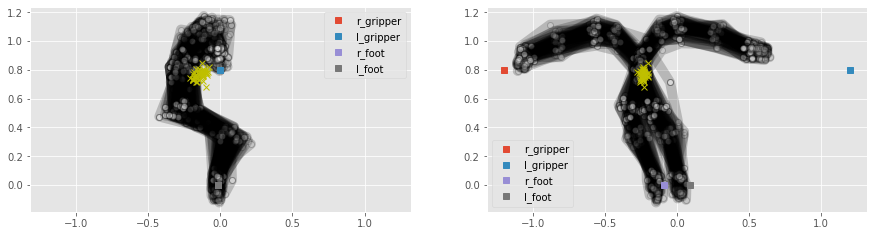

In [32]:
_links, _coms = sess.run(
    [links, coms], feed_dict={n_samples: 50})

fig, ax = plt.subplots(ncols=2, sharex=True, figsize=(15, 10))

for i in range(2):
    dim = [i, 2]
    chain.plot(
            _links, feed_dict={}, ax=ax[i],
            dim=dim, alpha=0.2, color='k'
        )    
    ax[i].plot(_coms[:, dim[0]], _coms[:, dim[1]], 'yx')
    
#     for j, name in enumerate(chain_names):
#         # print ee[name]
#         ax[i].plot(_ys_loc[j][0, dim[0]], _ys_loc[j][0, dim[1]], 'rs', color='orangered')

    for name in chain_names:
        ax[i].plot(feed_dict[locs[name]][dim[0]], feed_dict[locs[name]][dim[1]], ls=' ', marker='s', label=name)
        
    ax[i].legend()

### COM cost test

In [44]:
feed_dict[com_limits_std] = 0.01 # try to change this parameters with 0.001, 0.05, 
feed_dict[com_limits_temp] = 0.1

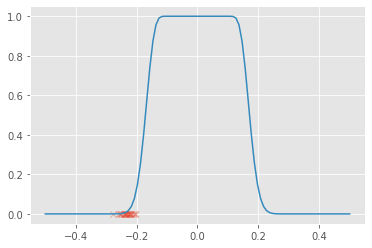

In [46]:
plt.plot(_coms[:, 1],
        np.zeros_like(_coms[:, 1]),
         marker='x', ls='', alpha=0.2)

feed_dict[com_disp_range] = [-0.5, 0.5]
plt.plot(np.linspace(feed_dict[com_disp_range][0], feed_dict[com_disp_range][1], 100), 
         np.exp(com_disp.eval(feed_dict)))

### Saving samples

In [34]:
_samples = sess.run(samples, {n_samples: 20000}) 

In [35]:
if not one_foot:
    np.save('data/talos_two_feet', _samples)
else:
    np.save('data/talos_one_foot_%s' % one_foot, _samples)
